In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from musichook.params import PATHS, SECRETS
from musichook.sound_similarity import audio_processing, spotify_api

from pydub import AudioSegment
from IPython.display import Audio, display

# Let's get a song preview from spotify to work with

In [3]:
# edit this cell to change the song. note that some songs may not be available.
song_name = 'Sexual Healing'

### Fetch the Spotify Song Preview of ~30 seconds

In [4]:
spotify = spotify_api.SpotifyAPI(SECRETS["CLIENT_ID"], SECRETS["CLIENT_SECRET"])
track_id = spotify.search_track_id(song_name)
preview_link = spotify.get_audio_link(track_id)
audio_path = spotify.download_audio(preview_link, PATHS["SPOTIFY_FOLDER"], f'{song_name}.mp3')

Audio file saved to: /Users/nicolas/code/Nico404/musichook/data/spotify/Sexual Healing.mp3


### Plot the chromagram of the Fetched Song preview

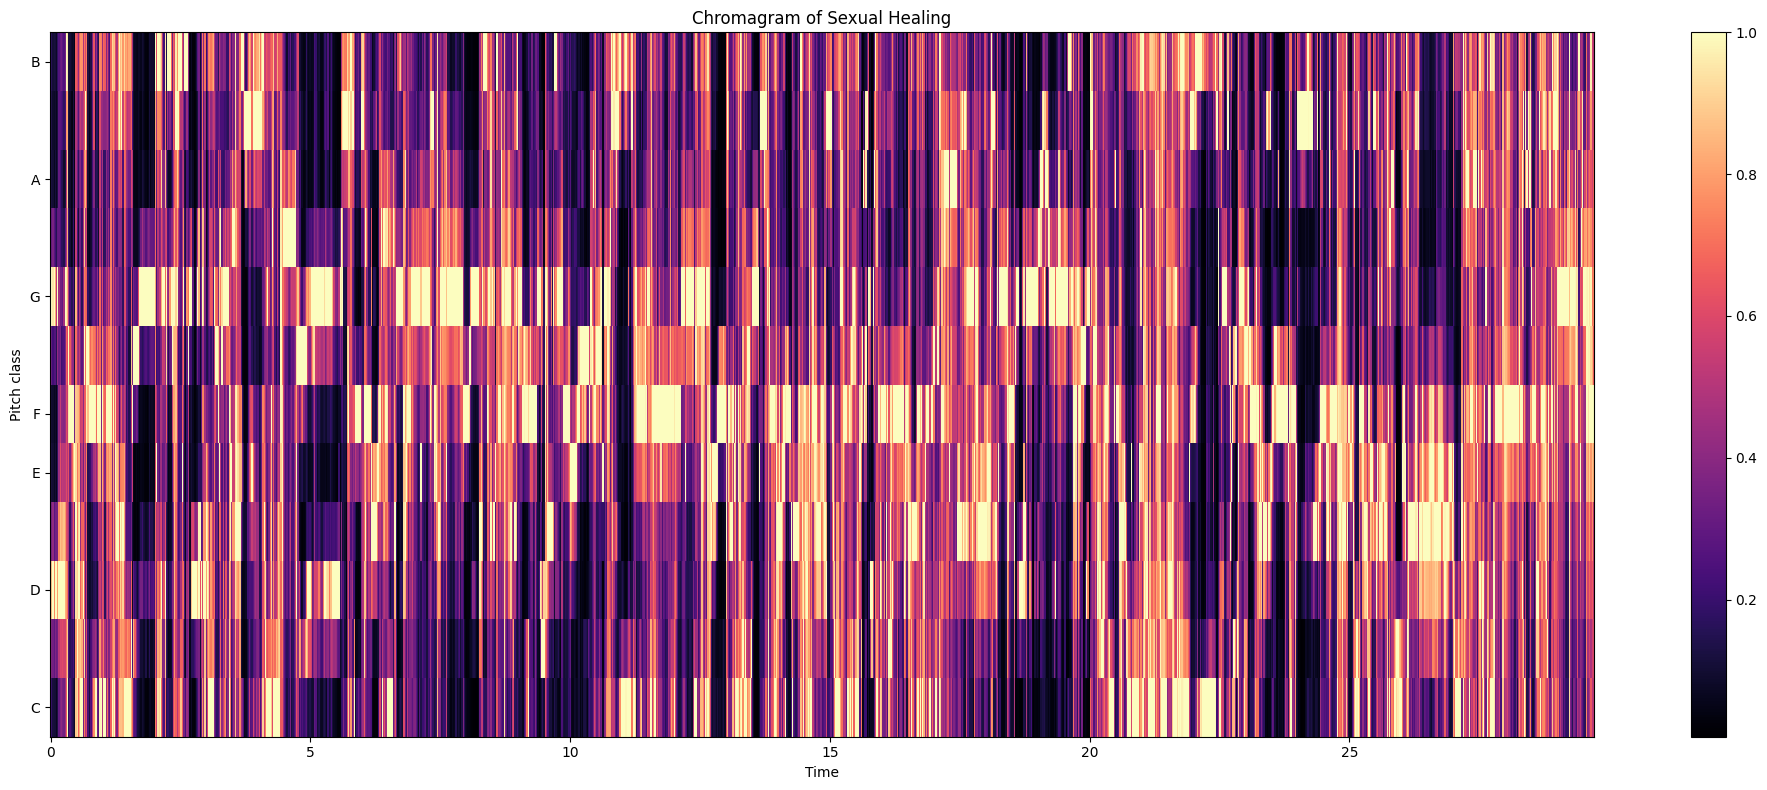

In [5]:
preview_audio = AudioSegment.from_file(audio_path)
preview_length = len(preview_audio) / 1000  # seconds
preview_chromagram = audio_processing.convert_to_chromagram(preview_audio)
audio_processing.display_chromagram(preview_chromagram, song_name)

# Now let's get the full song and cut it up into same size intervals

In [6]:
full_song_path = os.path.join(PATHS["MUSIC_FOLDER"], "065 - Sexual Healing By Marvin Gaye 320 - [kthor].mp3")
segments = audio_processing.cut_audio_into_sliding_intervals(full_song_path, interval_length=preview_length)
chromagrams = { i: audio_processing.convert_to_chromagram(segment) for i, segment in segments.items() }
print(len(chromagrams), "chromagrams created")

<pydub.audio_segment.AudioSegment object at 0x15d196560> 249.333
220 chromagrams created


### Let's compute SSIM and MSE between the spotify preview chromagram and each of the generated chromagrams

In [7]:
# calculate similarity and store into df without append (faster)
compare_results = list()
for i, chromagram in chromagrams.items():
    ssim, mse = audio_processing.compare_images(preview_chromagram, chromagram)
    compare_results.append({ "segment": i, "ssim": ssim, "mse": mse })

compare_df = pd.DataFrame(compare_results)
compare_df.sort_values(by='ssim', ascending=False)

,segment,ssim,mse
81,81,0.140113,0.151299
182,182,0.116862,0.155668
11,11,0.113046,0.160584
82,82,0.112976,0.157877
19,19,0.109416,0.161207
...,...,...,...
46,46,0.011199,0.172933
125,125,0.008857,0.172597
167,167,0.005924,0.175441
136,136,0.002029,0.173760


In [8]:
fig = px.line(compare_df, x='segment', y='ssim', title=f'SSIM Score for clips of {song_name}')
fig.show()

In [9]:
# get segment with maximum ssim
max_ssim_segment = int(compare_df.loc[compare_df['ssim'].idxmax()]['segment'])
print(f"segment_{max_ssim_segment} has the highest ssim of {compare_df['ssim'].max()}")

segment_81.mp3 has the highest ssim of 0.14011319609564643


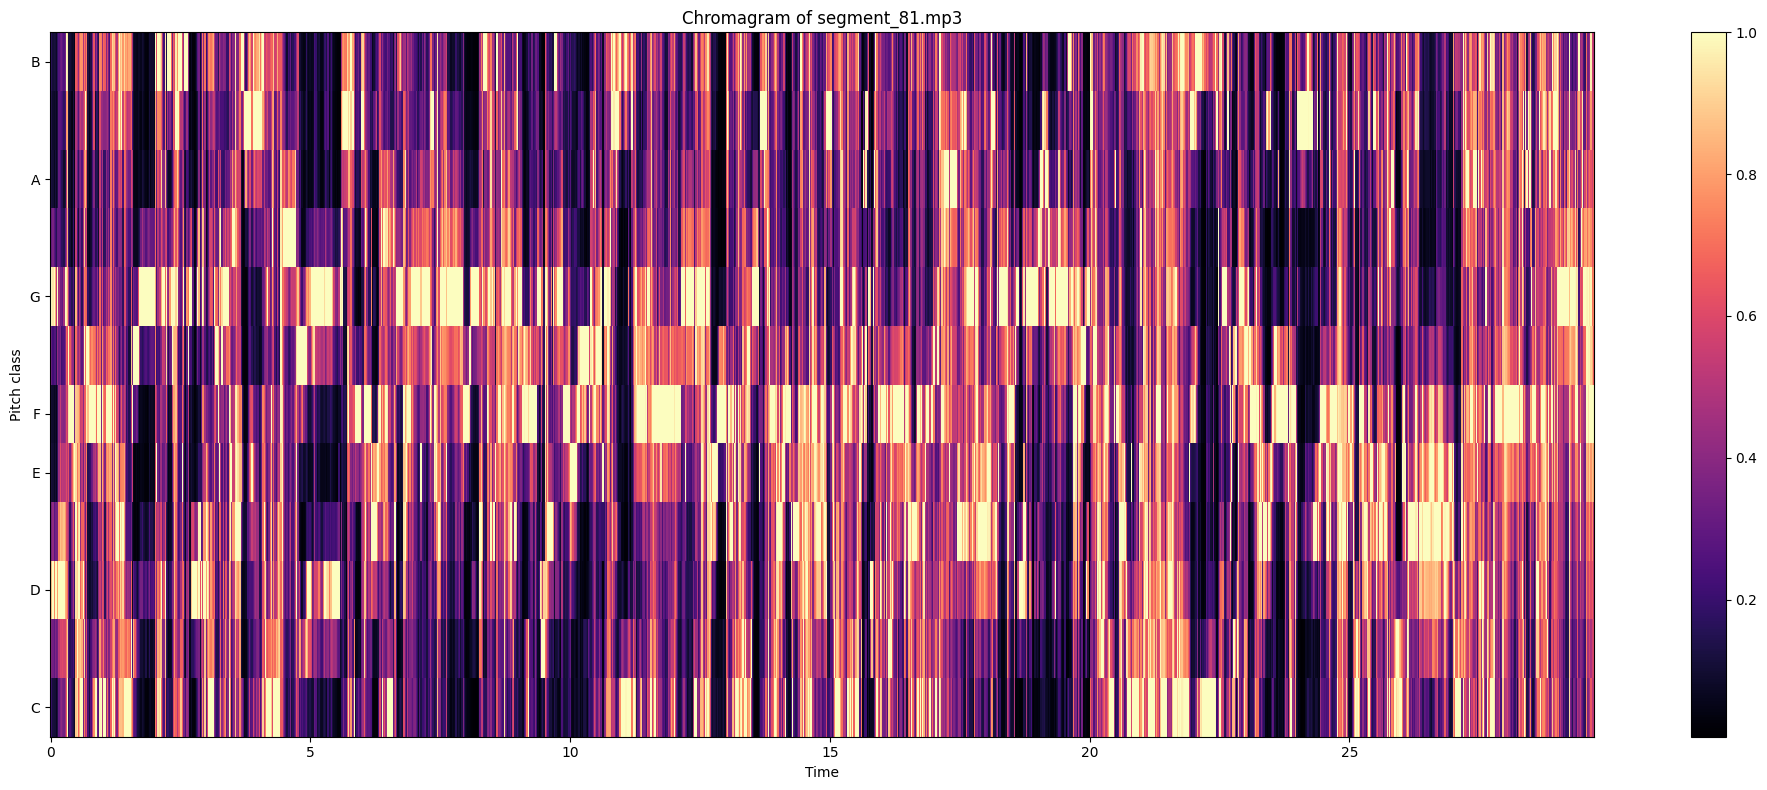

In [10]:
### Let's plot the chromagram of the segment with the highest ssim
audio_processing.display_chromagram(preview_chromagram, f"segment_{max_ssim_segment}.mp3")

# Let's play both to compare 

In [13]:
# Spotify extract
display(Audio(os.path.join(PATHS['SPOTIFY_FOLDER'], f"{song_name}.mp3")))

In [18]:
# Most similar segment
segments[max_ssim_segment]

In [31]:
# get the start and end times in the full song
audio_processing.get_segment_time(max_ssim_segment, preview_length)

('01:21', '01:50')